# Develop adjoint LBVP - example

## Option 1: Avoid convert

In [1]:
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import numpy as np

from dedalus.core import operators

from scipy import optimize

logger = logging.getLogger(__name__)


# Parameters
Ny = 128
dtype = np.complex128

# Bases
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.ChebyshevT(coords['y'], size=Ny,dealias=1, bounds=(0, 2))

y, = dist.local_grids(ybasis)

dy = lambda A: d3.Differentiate(A, coords['y'])

# Fields
u = dist.Field(name='u', bases=(ybasis))
v = dist.Field(name='v', bases=(ybasis))
w = dist.Field(name='w', bases=(ybasis))

gradu = dist.Field(name='gradu', bases=(ybasis))
gradv = dist.Field(name='gradv', bases=(ybasis))
gradw = dist.Field(name='gradw', bases=(ybasis))

U = dist.Field(name='U',bases=(ybasis))
U['g'] = y*(2-y)
Uy = dy(U)
alpha = -1
beta = 0
p = dist.Field(name='p', bases=(ybasis))
tau_u_1 = dist.Field(name='tau_u_1')
tau_u_2 = dist.Field(name='tau_u_2')

tau_v_1 = dist.Field(name='tau_v_1')
tau_v_2 = dist.Field(name='tau_v_2')

tau_w_1 = dist.Field(name='tau_w_1')
tau_w_2 = dist.Field(name='tau_w_2')

tau_p = dist.Field(name='tau_p')

ybasis2 = ybasis.derivative_basis(2)

# # Forcing
fu = dist.Field(name='fu',bases=(ybasis2))
fv = dist.Field(name='fv',bases=(ybasis2))
fw = dist.Field(name='fw',bases=(ybasis2))

# # Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
Re = 1000
omega = dist.Field(name='omega')
omega['g'] = 0.278
# # Problem
problem = d3.LBVP([u,v,w,p, tau_u_1, tau_u_2,tau_v_1, tau_v_2,tau_w_1, tau_w_2], namespace=locals())
problem.add_equation("1j*omega*u + 1j*alpha*u*U + v*Uy - 1/Re*(dy(dy(u))-alpha**2*u-beta**2*u) + lift(tau_u_1,-1) + lift(tau_u_2,-2) + 1j*alpha*p = fu")
problem.add_equation("1j*omega*v + 1j*alpha*v*U - 1/Re*(dy(dy(v))-alpha**2*v-beta**2*v) + lift(tau_v_1,-1) + lift(tau_v_2,-2) + dy(p) = fv")
problem.add_equation("1j*omega*w + 1j*alpha*w*U - 1/Re*(dy(dy(w))-alpha**2*w-beta**2*w) + lift(tau_w_1,-1) + lift(tau_w_2,-2) + 1j*beta*p = fw")
problem.add_equation("1j*alpha*u + dy(v) + 1j*beta*w = 0")

problem.add_equation("u(y=0) = 0")
problem.add_equation("u(y=2) = 0")

problem.add_equation("v(y=0) = 0")
problem.add_equation("v(y=2) = 0")

problem.add_equation("w(y=0) = 0")
problem.add_equation("w(y=2) = 0")

In [2]:
# Solver
solver = problem.build_solver()
# Check fu has the right bases to avoid convert
# print(fu.domain.bases[0])
# print(solver.F[0].domain.bases[0])

In [3]:
# Simple weight matrix using the Trapezium rule
# TODO: spectrally accurate weight matrix
def weightMatrixDisc():
    W = np.zeros(Ny)
    for i in range(Ny):
        if(i==0):
            W[i] = 0.5*(y[1]-y[0])
        elif(i==Ny-1):
            W[i] = 0.5*(y[Ny-1]-y[Ny-2])
        else:
            W[i] = 0.5*(y[i]-y[i-1]) + 0.5*(y[i+1]-y[i])
    return W
W = weightMatrixDisc()

In [4]:
def directAdjointLoopGrid(forcing):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Takes a field f forward via the Resolvent (LBVP)
    # Setup Direct problem

    fu['g'] = forcing[:Ny]+1j*forcing[Ny:2*Ny]
    fv['g'] = forcing[2*Ny:3*Ny]+1j*forcing[3*Ny:4*Ny]
    fw['g'] = forcing[4*Ny:5*Ny]+1j*forcing[5*Ny:6*Ny]
    
    forcNorm = np.sum(np.conj(fu['g'])*W*fu['g']).real
    forcNorm += np.sum(np.conj(fv['g'])*W*fv['g']).real
    forcNorm += np.sum(np.conj(fw['g'])*W*fw['g']).real

    solver.solve()

    cost = np.sum(np.conj(solver.state[0]['g'])*W*solver.state[0]['g']).real
    cost += np.sum(np.conj(solver.state[1]['g'])*W*solver.state[1]['g']).real
    cost += np.sum(np.conj(solver.state[2]['g'])*W*solver.state[2]['g']).real

    cost = cost/forcNorm
        
    solver.state_adj[0]['g'] = W*u['g']/forcNorm
    solver.state_adj[1]['g'] = W*v['g']/forcNorm
    solver.state_adj[2]['g'] = W*w['g']/forcNorm
    
    solver.solve_adjoint()
    
    gradu['g'] = -cost/forcNorm*W*fu['g']  + solver.F_adj[0]['g']
    gradv['g'] = -cost/forcNorm*W*fv['g']  + solver.F_adj[1]['g']
    gradw['g'] = -cost/forcNorm*W*fw['g']  + solver.F_adj[2]['g']

    graduDat = np.hstack((gradu['g'].real,gradu['g'].imag))
    gradvDat = np.hstack((gradv['g'].real,gradv['g'].imag))
    gradwDat = np.hstack((gradw['g'].real,gradw['g'].imag))
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    # Return negative values so maximisation -> minimisation
    return -cost, -grad

In [5]:
opts = {'disp': True}
forcing = np.random.rand(Ny*2*3)

sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True,options=opts)

2023-03-07 14:41:20,214 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+00/s
2023-03-07 14:41:20,272 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27175D+01    |proj g|=  8.13788D-01

At iterate    1    f= -7.49199D+02    |proj g|=  1.12646D+00

At iterate    2    f= -8.52840D+02    |proj g|=  1.80843D-01

At iterate    3    f= -8.80618D+02    |proj g|=  1.39472D-01

At iterate    4    f= -9.02116D+02    |proj g|=  5.60443D-02

At iterate    5    f= -9.03679D+02    |proj g|=  5.23299D-02

At iterate    6    f= -9.06083D+02    |proj g|=  4.57166D-02

At iterate    7    f= -9.06945D+02    |proj g|=  2.78227D-02

At iterate    8    f= -9.07535D+02    |proj g|=  1.41982D-02

At iterate

 This problem is unconstrained.


Text(0.5, 1.0, 'Optimal response')

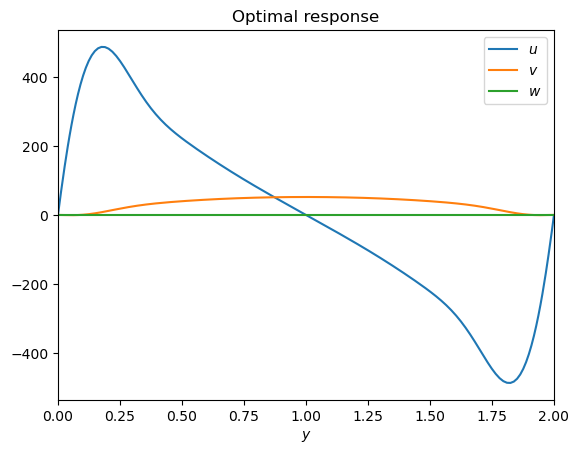

In [6]:
plt.plot(y,u['g'].real,label=r'$u$')
plt.plot(y,v['g'].real,label=r'$v$')
plt.plot(y,w['g'].real,label=r'$w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title('Optimal response')

Text(0.5, 1.0, 'Optimal forcing')

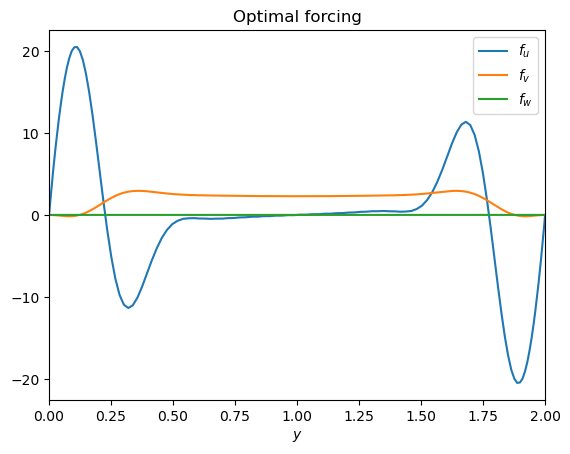

In [7]:
plt.plot(y,fu['g'].real,label=r'$f_u$')
plt.plot(y,fv['g'].real,label=r'$f_v$')
plt.plot(y,fw['g'].real,label=r'$f_w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title('Optimal forcing')

In [8]:
%%time
omegas = np.linspace(0.1,1.5,120)
gains = []
for omega_v in omegas:
    omega['g'] = omega_v
    solver = problem.build_solver()
    sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True)
    gains.append(sol.fun)
gains = -np.array(gains)

2023-03-07 14:41:21,074 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-03-07 14:41:21,117 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 14:41:21,236 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 14:41:21,279 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 14:41:21,399 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 14:41:21,442 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 14:41:21,564 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:21,610 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 14:41:26,439 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 14:41:26,582 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 14:41:26,624 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 14:41:26,752 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 14:41:26,794 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 14:41:26,912 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:26,954 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:27,092 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 14:41:32,074 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:32,115 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:32,236 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:32,277 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:32,398 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:32,439 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:32,568 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 14:41:32,611 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 14:41:37,137 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:37,245 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:37,286 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:37,399 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 14:41:37,439 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:37,546 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:37,588 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:37,698 subsystems 0/1 INFO :: Building subproblem matrices 

(0.1, 1.5)

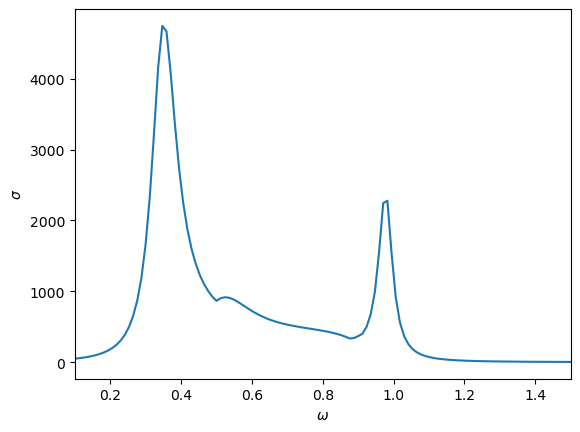

In [9]:
plt.plot(omegas,gains)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\sigma$')
plt.xlim([omegas[0],omegas[-1]])

## Option 2: with adjoint convert

In [10]:
# Forcing
fu2 = dist.Field(name='fu',bases=(ybasis))
fv2 = dist.Field(name='fv',bases=(ybasis))
fw2 = dist.Field(name='fw',bases=(ybasis))

# # Problem
problem2 = d3.LBVP([u,v,w,p, tau_u_1, tau_u_2,tau_v_1, tau_v_2,tau_w_1, tau_w_2], namespace=locals())
problem2.add_equation("1j*omega*u + 1j*alpha*u*U + v*Uy - 1/Re*(dy(dy(u))-alpha**2*u-beta**2*u) + lift(tau_u_1,-1) + lift(tau_u_2,-2) + 1j*alpha*p = fu2")
problem2.add_equation("1j*omega*v + 1j*alpha*v*U - 1/Re*(dy(dy(v))-alpha**2*v-beta**2*v) + lift(tau_v_1,-1) + lift(tau_v_2,-2) + dy(p) = fv2")
problem2.add_equation("1j*omega*w + 1j*alpha*w*U - 1/Re*(dy(dy(w))-alpha**2*w-beta**2*w) + lift(tau_w_1,-1) + lift(tau_w_2,-2) + 1j*beta*p = fw2")
problem2.add_equation("1j*alpha*u + dy(v) + 1j*beta*w = 0")

problem2.add_equation("u(y=0) = 0")
problem2.add_equation("u(y=2) = 0")

problem2.add_equation("v(y=0) = 0")
problem2.add_equation("v(y=2) = 0")

problem2.add_equation("w(y=0) = 0")
problem2.add_equation("w(y=2) = 0")

In [11]:
# Solver
solver2 = problem2.build_solver()
# Check fu2 has the different bases so adjoint connvert needed
print(fu2.domain.bases[0])
print(solver2.F[0].domain.bases[0])

Jacobi(y, 128, a0=-0.5, b0=-0.5, a=-0.5, b=-0.5, dealias=1)
Jacobi(y, 128, a0=-0.5, b0=-0.5, a=1.5, b=1.5, dealias=1)


In [12]:
def directAdjointLoopGridConvert(forcing):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Takes a field f forward via the Resolvent (LBVP)
    # Setup Direct problem

    
    fu2['g'] = forcing[:Ny]+1j*forcing[Ny:2*Ny]
    fv2['g'] = forcing[2*Ny:3*Ny]+1j*forcing[3*Ny:4*Ny]
    fw2['g'] = forcing[4*Ny:5*Ny]+1j*forcing[5*Ny:6*Ny]
    
    forcNorm = np.sum(np.conj(fu2['g'])*W*fu2['g']).real
    forcNorm += np.sum(np.conj(fv2['g'])*W*fv2['g']).real
    forcNorm += np.sum(np.conj(fw2['g'])*W*fw2['g']).real

    solver2.solve()

    cost = np.sum(np.conj(solver2.state[0]['g'])*W*solver2.state[0]['g']).real
    cost += np.sum(np.conj(solver2.state[1]['g'])*W*solver2.state[1]['g']).real
    cost += np.sum(np.conj(solver2.state[2]['g'])*W*solver2.state[2]['g']).real

    cost = cost/forcNorm
    
    solver2.state_adj[0]['g'] = W*u['g']/forcNorm
    solver2.state_adj[1]['g'] = W*v['g']/forcNorm
    solver2.state_adj[2]['g'] = W*w['g']/forcNorm
        
    solver2.solve_adjoint()
    
    # Now needed to adjoint convert!!! #
    # solver.F_adj is in adjoint second derivative basis
    # so after convert need a adjoint no derivative basis like state_adj
    F_adj0 = solver2.state_adj[0].copy()
    F_adj1 = solver2.state_adj[1].copy()
    F_adj2 = solver2.state_adj[2].copy()
    
    # Uncomment next three lines to check that convert works using adjoint bases of solver.F_adj
#     solver.F_adj[0]['g']
#     solver.F_adj[1]['g']
#     solver.F_adj[2]['g']
    
    convert = operators.convert(fu2, (ybasis2,))
    convert.operate_adjoint(solver2.F_adj[0],F_adj0)
    convert.operate_adjoint(solver2.F_adj[1],F_adj1)
    convert.operate_adjoint(solver2.F_adj[2],F_adj2)
    ####################################
    
    gradu['g'] = -cost/forcNorm*W*fu2['g']  + F_adj0['g']
    gradv['g'] = -cost/forcNorm*W*fv2['g']  + F_adj1['g']
    gradw['g'] = -cost/forcNorm*W*fw2['g']  + F_adj2['g']

    graduDat = np.hstack((gradu['g'].real,gradu['g'].imag))
    gradvDat = np.hstack((gradv['g'].real,gradv['g'].imag))
    gradwDat = np.hstack((gradw['g'].real,gradw['g'].imag))
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    # Return negative values so maximisation -> minimisation
    return -cost, -grad

In [13]:
%%time
omegas = np.linspace(0.1,1.5,120)
gains2 = []
for omega_v in omegas:
    omega['g'] = omega_v
    solver2 = problem2.build_solver()
    sol = optimize.minimize(directAdjointLoopGridConvert,forcing,method='L-BFGS-B',jac=True)
    gains2.append(sol.fun)
gains2 = -np.array(gains2)

2023-03-07 14:41:41,018 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-03-07 14:41:41,059 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 14:41:41,187 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 14:41:41,230 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 14:41:41,355 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 14:41:41,398 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 14:41:41,526 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 14:41:41,570 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 14:41:46,484 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:46,623 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 14:41:46,665 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 14:41:46,794 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:46,836 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 14:41:46,962 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 14:41:47,004 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:47,154 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 14:41:52,302 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:52,343 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:52,469 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-07 14:41:52,510 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:52,640 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-07 14:41:52,683 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-07 14:41:52,815 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:52,857 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-07 14:41:57,572 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:57,693 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:57,737 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-07 14:41:57,854 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:57,895 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:58,008 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-07 14:41:58,049 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-07 14:41:58,162 subsystems 0/1 INFO :: Building subproblem matrices 

(0.1, 1.5)

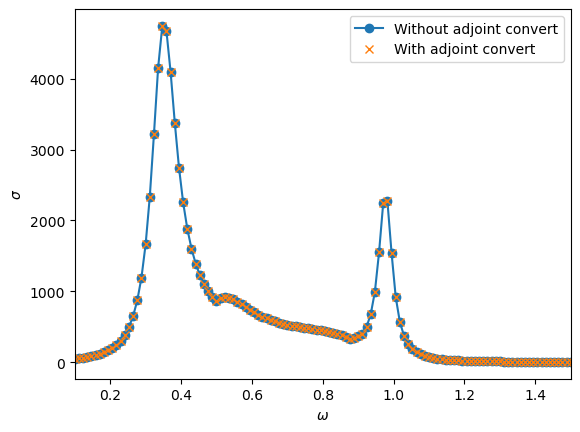

In [14]:
# Check same results as those with convert
plt.plot(omegas,gains,'-o',label=r'Without adjoint convert')
plt.plot(omegas,gains2,'x',label=r'With adjoint convert')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\sigma$')
plt.legend()
plt.xlim([omegas[0],omegas[-1]])